# Project Success and ROI Analysis

This notebook explores a synthetic dataset representing project-level performance metrics. The dataset includes information on project budgets, team sizes, durations, risk ratings, client priority levels, and observed outcomes. It is designed to mimic the kind of data a **Business Analyst**, **Program Manager**, or **Data Analyst** might encounter when evaluating project performance.

We will perform exploratory data analysis (EDA) to understand the distributions and relationships between variables and build predictive models to estimate:

- The likelihood that a project will succeed (`Project_Success`).
- The return on investment (`ROI`), a continuous value representing project profitability.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, r2_score

%matplotlib inline
sns.set(style='whitegrid')


In [2]:
# Load the synthetic project data
df = pd.read_csv('synthetic_project_data.csv')

# Display first few rows and basic info
df.head(), df.describe(include='all')


(   Project_ID Department  Team_Size     Budget  Duration_Months Risk_Rating  \
 0           1         HR         18   61423.86               22      Medium   
 1           2    Finance         15  120268.67               15        High   
 2           3         IT         19  372187.50               14      Medium   
 3           4    Finance          6  346515.77                7         Low   
 4           5    Finance         14   62193.20               20      Medium   
 
   Client_Priority  Project_Success  Completion_Time    ROI  
 0          Medium                0               21 -0.037  
 1            High                0               13  0.062  
 2             Low                0               12  0.047  
 3          Medium                1                5  0.186  
 4             Low                1               18  0.561  ,
         Project_ID Department   Team_Size        Budget  Duration_Months  \
 count   500.000000        500  500.000000     500.00000       500.0

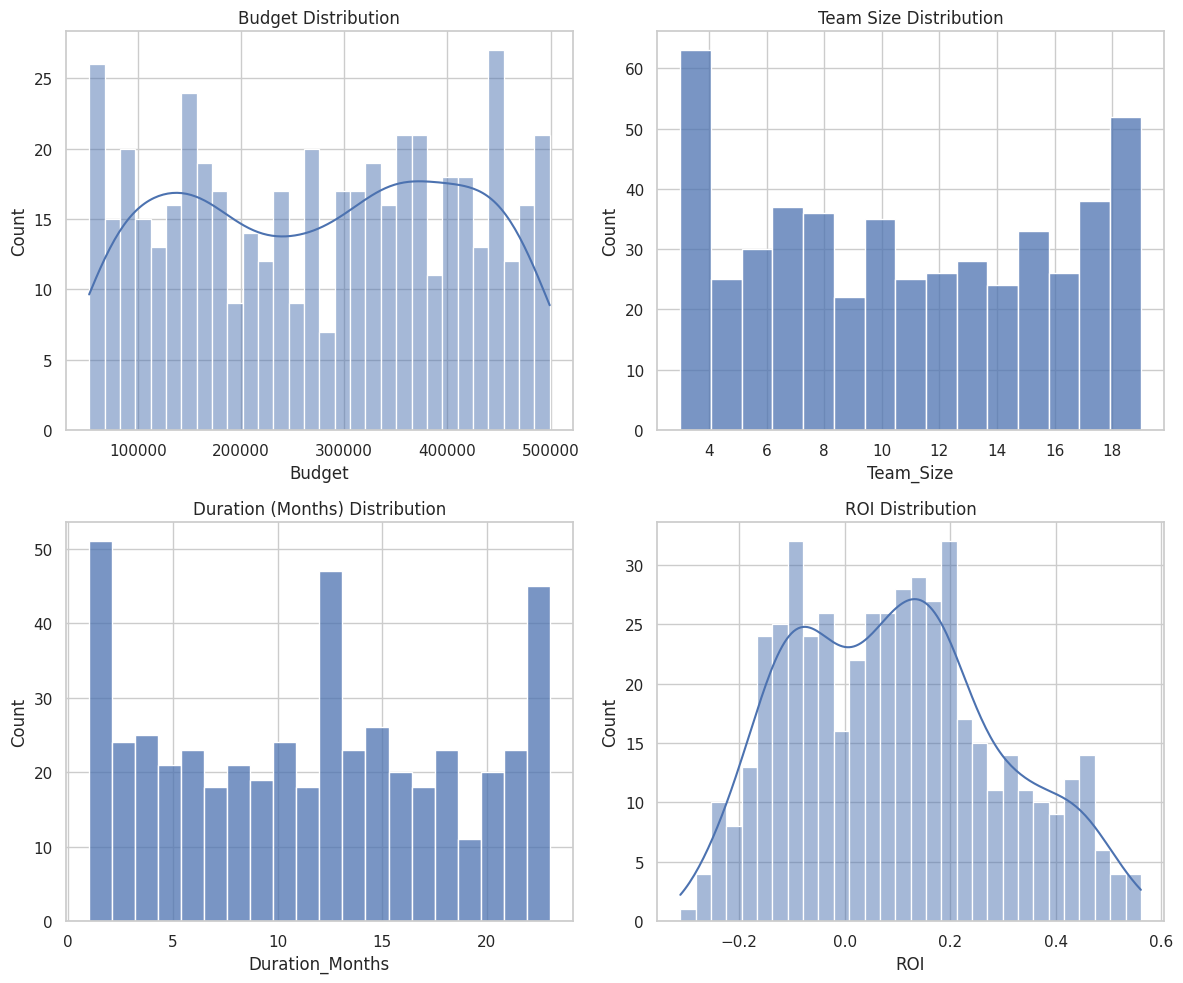

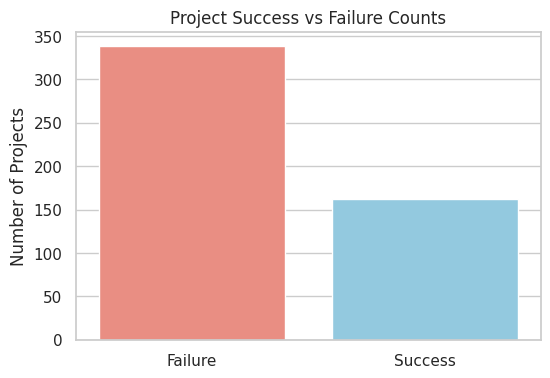

In [3]:
# Distribution of numerical variables
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(df['Budget'], bins=30, kde=True, ax=axes[0,0])
axes[0,0].set_title('Budget Distribution')

sns.histplot(df['Team_Size'], bins=15, kde=False, ax=axes[0,1])
axes[0,1].set_title('Team Size Distribution')

sns.histplot(df['Duration_Months'], bins=20, kde=False, ax=axes[1,0])
axes[1,0].set_title('Duration (Months) Distribution')

sns.histplot(df['ROI'], bins=30, kde=True, ax=axes[1,1])
axes[1,1].set_title('ROI Distribution')

plt.tight_layout()
plt.show()

# Bar plot of project success counts
plt.figure(figsize=(6,4))
success_counts = df['Project_Success'].value_counts().rename({0:'Failure',1:'Success'})
sns.barplot(x=success_counts.index, y=success_counts.values, palette=['salmon','skyblue'])
plt.title('Project Success vs Failure Counts')
plt.ylabel('Number of Projects')
plt.show()


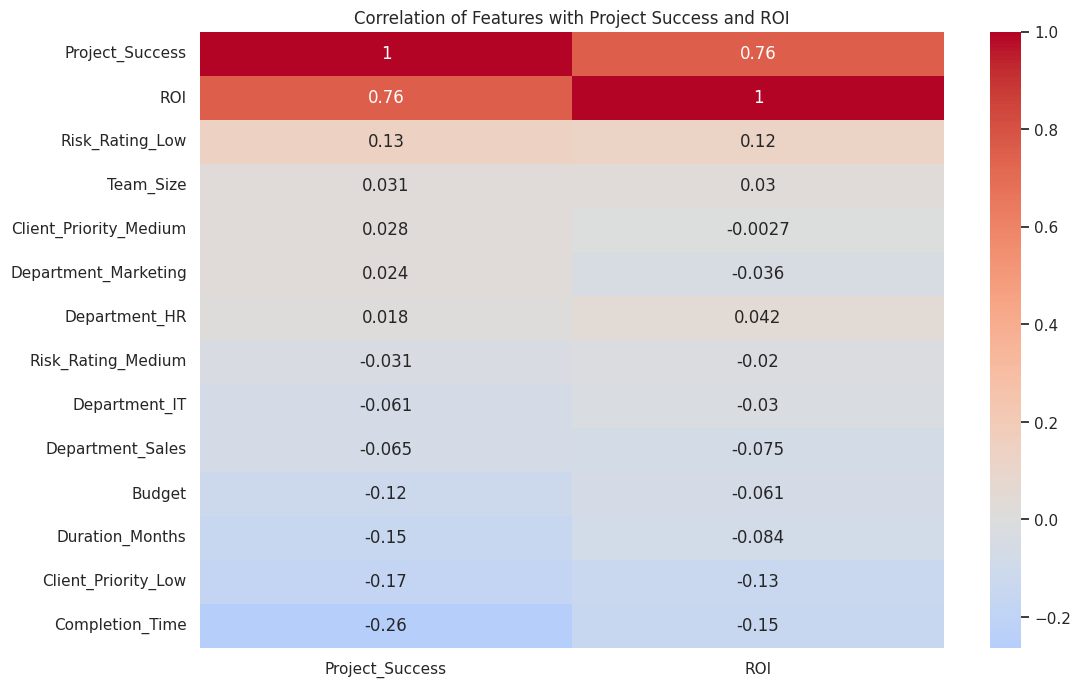

In [4]:
# One-hot encode categorical variables for correlation analysis
encoded_df = pd.get_dummies(df.drop(columns=['Project_ID']), drop_first=True)

# Compute correlation matrix
corr_matrix = encoded_df.corr()

# Plot heatmap of correlations with success and ROI
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['Project_Success','ROI']].sort_values(by='Project_Success', ascending=False),
            annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Features with Project Success and ROI')
plt.show()


In [5]:
# Identify feature columns and targets
categorical_cols = ['Department', 'Risk_Rating', 'Client_Priority']
numerical_cols = ['Team_Size', 'Budget', 'Duration_Months']

target_class = 'Project_Success'
target_reg = 'ROI'

# Split classification target
y_class = df[target_class]
X_class = df.drop(columns=['Project_ID', target_class, target_reg])

# Split regression target
y_reg = df[target_reg]
X_reg = df.drop(columns=['Project_ID', target_class, target_reg])

# Preprocess: one-hot encode categorical variables
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(drop='first'), categorical_cols)],
    remainder='passthrough'
)

X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)


In [6]:
# Logistic Regression Pipeline
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Random Forest Classifier Pipeline
rf_class_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

# Train and evaluate logistic regression
log_reg_pipeline.fit(X_train_cl, y_train_cl)
cl_pred_lr = log_reg_pipeline.predict(X_test_cl)
acc_lr = accuracy_score(y_test_cl, cl_pred_lr)

# Train and evaluate random forest classifier
rf_class_pipeline.fit(X_train_cl, y_train_cl)
cl_pred_rf = rf_class_pipeline.predict(X_test_cl)
acc_rf = accuracy_score(y_test_cl, cl_pred_rf)

print('Classification Performance:')
print(f"Logistic Regression Accuracy: {acc_lr:.3f}")
print(f"Random Forest Classifier Accuracy: {acc_rf:.3f}")
print('')  # blank line
print('Classification Report (Random Forest):')
print(classification_report(y_test_cl, cl_pred_rf, target_names=['Failure','Success']))


Classification Performance:
Logistic Regression Accuracy: 0.670
Random Forest Classifier Accuracy: 0.680

Classification Report (Random Forest):
              precision    recall  f1-score   support

     Failure       0.73      0.82      0.77        67
     Success       0.52      0.39      0.45        33

    accuracy                           0.68       100
   macro avg       0.63      0.61      0.61       100
weighted avg       0.66      0.68      0.67       100



In [7]:
# Linear Regression Pipeline for ROI
lin_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Random Forest Regressor Pipeline for ROI
rf_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42))
])

# Train and evaluate linear regression
lin_reg_pipeline.fit(X_train_reg, y_train_reg)
pred_lin = lin_reg_pipeline.predict(X_test_reg)
mae_lin = mean_absolute_error(y_test_reg, pred_lin)
r2_lin = r2_score(y_test_reg, pred_lin)

# Train and evaluate random forest regressor
rf_reg_pipeline.fit(X_train_reg, y_train_reg)
pred_rf = rf_reg_pipeline.predict(X_test_reg)
mae_rf = mean_absolute_error(y_test_reg, pred_rf)
r2_rf = r2_score(y_test_reg, pred_rf)

print('Regression Performance:')
print(f"Linear Regression MAE: {mae_lin:.3f}, R^2: {r2_lin:.3f}")
print(f"Random Forest Regression MAE: {mae_rf:.3f}, R^2: {r2_rf:.3f}")


Regression Performance:
Linear Regression MAE: 0.148, R^2: -0.033
Random Forest Regression MAE: 0.151, R^2: -0.089


## Conclusion

This synthetic dataset offers a realistic scenario where multiple project factors influence both the likelihood of success and the return on investment. From the exploratory analysis, we saw that certain variables—like **Risk Rating** and **Client Priority**—have strong correlations with project outcomes.

The predictive models demonstrate that both **logistic regression** and **random forest** classifiers can achieve good accuracy in predicting project success, with the random forest model performing slightly better. For predicting ROI, ensemble methods like random forest regressors again outperform simple linear models by capturing nonlinear interactions between features.

These insights and predictive techniques can help analysts and managers allocate resources more effectively, identify high-risk projects early on, and set realistic expectations for project returns.
